## Pretrained GAN

In [ ]:
from fastai2.vision.all import *
from fastai2.vision.gan import *

In [ ]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

Prepare the input data by crappifying images.

In [ ]:
from crappify import *

Uncomment the first time you run this notebook.

In [ ]:
#items = get_image_files(path_hr)
#parallel(crappifier(path_lr, path_hr), items);

For gradual resizing we can change the commented line here.

In [ ]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256
arch = resnet34

## Pre-train generator

Now let's pretrain the generator.

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, ImageBlock),
                   get_items=get_image_files,
                   get_y=lambda x: path_hr/x.name,
                   splitter=RandomSplitter())

In [ ]:
def get_dbunch(bs,size):
    dbunch = dblock.databunch(path_lr, bs=bs, path=path, item_tfms=Resize(size),
                              batch_tfms=[*aug_transforms(max_zoom=2.), Normalize.from_stats(*imagenet_stats)])         
    dbunch.c = 3
    return dbunch

In [ ]:
dbunch_gen = get_dbunch(bs,size)

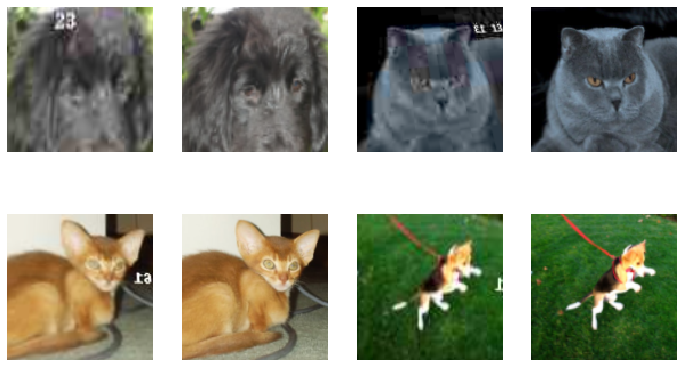

In [ ]:
dbunch_gen.show_batch(max_n=4)

In [ ]:
wd = 1e-3

In [ ]:
y_range = (-3.,3.)

In [ ]:
loss_gen = MSELossFlat()

In [ ]:
def create_gen_learner():
    return unet_learner(dbunch_gen, arch, loss_func=loss_gen, 
                        config=unet_config(blur=True, norm_type=NormType.Weight, self_attention=True, y_range=y_range))

In [ ]:
learn_gen = create_gen_learner()

In [ ]:
learn_gen.fit_one_cycle(2, pct_start=0.8, wd=wd)

epoch,train_loss,valid_loss,time
0,0.040852,0.036267,00:52
1,0.021004,0.025883,00:47


In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3), wd=wd)

epoch,train_loss,valid_loss,time
0,0.019924,0.027299,00:52
1,0.018458,0.024429,00:51
2,0.017787,0.023977,00:51


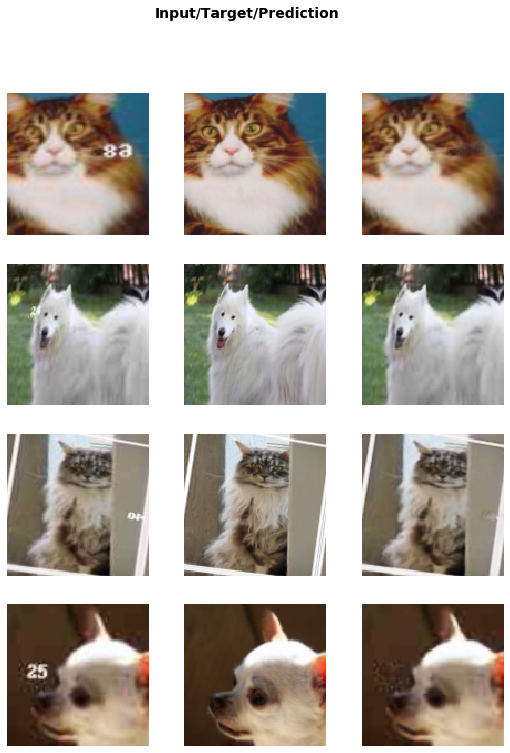

In [ ]:
learn_gen.show_results(max_n=4)

In [ ]:
learn_gen.save('gen-pre2')

## Save generated images

In [ ]:
learn_gen.load('gen-pre2');

In [ ]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [ ]:
#shutil.rmtree(path_gen)

In [ ]:
path_gen.mkdir(exist_ok=True)

In [ ]:
def save_preds(dl, learn):
    names = dl.dataset.items
    
    preds,_ = learn.get_preds(dl=dl)
    for i,pred in enumerate(preds):
        dec = dl.after_batch.decode((TensorImage(pred[None]),))[0][0]
        arr = dec.numpy().transpose(1,2,0)
        Image.fromarray(np.uint8(arr*255), mode='RGB').save(path_gen/names[i].name)

Remove shuffle, drop_last and data aug from the training set

In [ ]:
dbunch_gen.train_dl.after_batch

Pipeline: (#5) [Cuda: False (object,object) -> encodes (object,object) -> decodes,IntToFloatTensor: False (TensorMask,object) -> encodes
(TensorImage,object) -> encodes (TensorImage,object) -> decodes,AffineCoordTfm: False (TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
(TensorImage,object) -> encodes
(TensorMask,object) -> encodes ,LightingTfm: False (TensorImage,object) -> encodes ,Normalize: False (TensorImage,object) -> encodes (TensorImage,object) -> decodes]

In [ ]:
dl = dbunch_gen.train_dl.new(shuffle=False, drop_last=False, after_batch=[Cuda, IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In [ ]:
save_preds(dl, learn_gen)

## Train critic

Pretrain the critic on crappy vs not crappy.

In [ ]:
crit_dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_image_files, folders=[name_gen, 'images']),
                   get_y=parent_label,
                   splitter=RandomSplitter(0.1, seed=42))

In [ ]:
def get_crit_dbunch(bs,size):
    return crit_dblock.databunch(path, bs=bs, path=path, item_tfms=Resize(size),
                              batch_tfms=[Normalize.from_stats(*imagenet_stats)])         

In [ ]:
dbunch_crit = get_crit_dbunch(bs=bs, size=size)

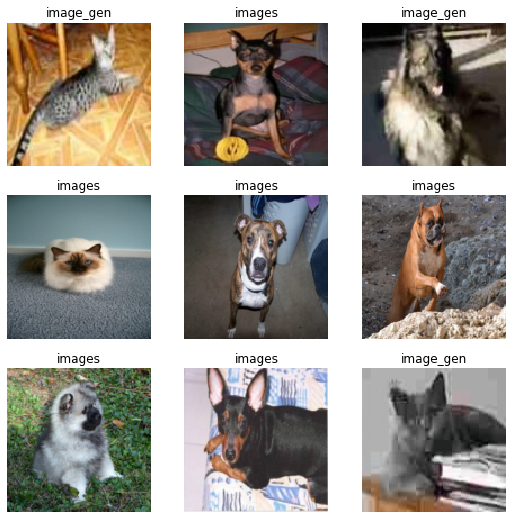

In [ ]:
dbunch_crit.show_batch()

In [ ]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [ ]:
def create_critic_learner(dbunch, metrics):
    return Learner(dbunch, gan_critic(), metrics=metrics, loss_func=loss_critic)

In [ ]:
learn_critic = create_critic_learner(dbunch_crit, accuracy_thresh_expand)

In [ ]:
learn_critic.fit_one_cycle(6, 1e-3, wd=wd)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.690184,0.687914,0.559398,01:38
1,0.682592,0.681888,0.559398,01:39
2,0.384733,0.272788,0.880932,01:40
3,0.089558,0.032649,0.992572,01:40
4,0.027889,0.015396,0.996060,01:39
5,0.021171,0.011879,0.996752,01:40


In [ ]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [ ]:
crit_dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=partial(get_image_files, folders=['crappy', 'images']),
                   get_y=parent_label,
                   splitter=RandomSplitter(0.1, seed=42))

In [ ]:
dbunch_crit = get_crit_dbunch(bs=bs, size=size)

In [ ]:
learn_crit = create_critic_learner(dbunch_crit, metrics=None).load('critic-pre2')

In [ ]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects foor the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [ ]:
class GANDiscriminativeLR(Callback):
    "`Callback` that handles multiplying the learning rate by `mult_lr` for the critic."
    def __init__(self, mult_lr=5.): self.mult_lr = mult_lr

    def begin_batch(self):
        "Multiply the current lr if necessary."
        if not self.learn.gan_trainer.gen_mode and self.training: 
            self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']*self.mult_lr)

    def after_batch(self):
        "Put the LR back to its value if necessary."
        if not self.learn.gan_trainer.gen_mode: self.learn.opt.set_hyper('lr', learn.opt.hypers[0]['lr']/self.mult_lr)

In [ ]:
switcher = AdaptiveGANSwitcher(critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(Adam, mom=0.), cbs=GANDiscriminativeLR(mult_lr=5.))

In [ ]:
lr = 1e-4

In [ ]:
learn.fit(10, lr, wd=wd)

epoch,train_loss,valid_loss,gen_loss,crit_loss,time
0,1.427999,2.563505,2.563505,0.396655,01:40
1,1.461367,1.850953,1.850953,0.531291,01:36
2,1.376163,2.435306,2.435306,0.457159,01:38
3,1.398360,2.643972,2.643972,0.347387,01:38
4,1.502232,3.334330,3.334330,0.384504,01:37
5,1.536205,3.519342,3.519342,0.635710,01:37
6,1.552404,3.038724,3.038724,0.362836,01:37
7,1.573182,3.727117,3.727117,0.348866,01:38
8,1.552637,3.170679,3.170679,0.245931,01:37
9,1.647171,2.889551,2.889551,0.261325,01:37


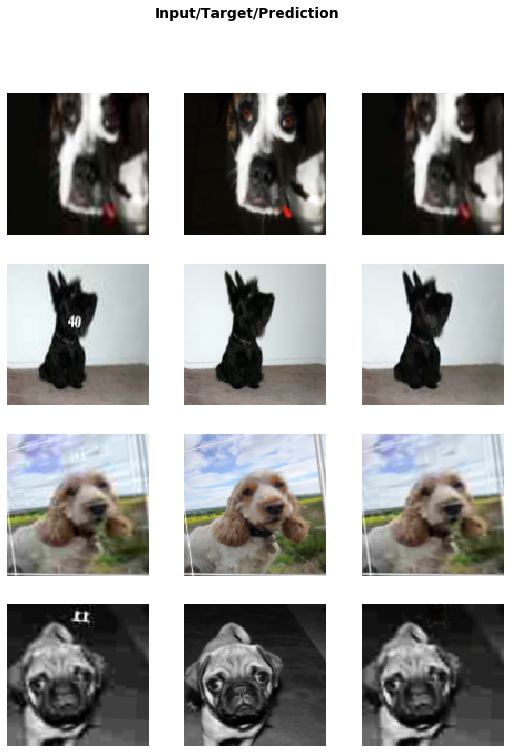

In [ ]:
learn.show_results(max_n=4)

## fin